This is the EDA, cleaning, and modeling notebook for the GA Hackathon Kaggle competition. I've selected the Shelter Animal Outcomes Classification Problem dataset. Let's load in the libraries that I'll need here:

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.constraints import maxnorm

Let's read in the data:

In [2]:
pets = pd.read_csv('./train.csv.gz')
pets.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
pets['OutcomeType'].value_counts(normalize = True)

Adoption           0.402896
Transfer           0.352501
Return_to_owner    0.179056
Euthanasia         0.058177
Died               0.007370
Name: OutcomeType, dtype: float64

So here, we can see that our majority class is 'Adoption' (thankfully), and if we just predicted Adoption for every outcome, we would be right 40% of the time. That's our baseline accuracy.

We can also see that there are five possible outcomes, so we're dealing with a multiclass classification problem.

In [4]:
pets.shape

(26729, 10)

In [5]:
pets.dtypes

AnimalID          object
Name              object
DateTime          object
OutcomeType       object
OutcomeSubtype    object
AnimalType        object
SexuponOutcome    object
AgeuponOutcome    object
Breed             object
Color             object
dtype: object

In [6]:
pets.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [7]:
pets['Breed'].value_counts()

Domestic Shorthair Mix               8810
Pit Bull Mix                         1906
Chihuahua Shorthair Mix              1766
Labrador Retriever Mix               1363
Domestic Medium Hair Mix              839
                                     ... 
Australian Cattle Dog/Rat Terrier       1
Dachshund/Belgian Malinois              1
Dachshund Wirehair/Rat Terrier          1
Pug/Italian Greyhound                   1
Miniature Poodle/Havanese               1
Name: Breed, Length: 1380, dtype: int64

We're gonna do a little data cleaning here: We'll fill in the animal names we don't know with 'X,' and drop the values we're missing for AgeuponOutcome and SexuponOutcome, because there are just a few of them.

In [8]:
pets['Name'] = pets['Name'].fillna('X')

In [9]:
pets = pets.dropna(subset=['AgeuponOutcome', 'SexuponOutcome'])

In [10]:
pets.shape

(26710, 10)

In [11]:
X = pets.drop(columns = ['OutcomeType', 'OutcomeSubtype'])
y = pets.OutcomeType

In [12]:
y.shape

(26710,)

In [13]:
X.shape

(26710, 8)

In order to use most of my X dataframe, I'll have to dummify the variables. However, most of the columns have a significant number of categories, which will create too many features. First, I'll deal with the DateTime column, so I don't lose that information:

In [14]:
X['DateTime'] = pd.to_datetime(X['DateTime'])

In [15]:
X['year_month'] = X['DateTime'].map(lambda x: 100*x.year + x.month)

In [16]:
X['year'] = X['DateTime'].map(lambda x: x.year)

In [17]:
X['Month'] = X['DateTime'].map(lambda x: x.month)

In [18]:
X.dtypes

AnimalID                  object
Name                      object
DateTime          datetime64[ns]
AnimalType                object
SexuponOutcome            object
AgeuponOutcome            object
Breed                     object
Color                     object
year_month                 int64
year                       int64
Month                      int64
dtype: object

Okay, now we need to drop the features that have too high cardinality in order to dummify the X variable. Let's set the maximum cardinality for a given feature to be 100:

In [19]:
max_cardinality = 100

high_cardinality = [col for col in X.select_dtypes(exclude=np.number)
                   if X[col].nunique() > max_cardinality]

X = X.drop(columns=high_cardinality)

However, despite its high cardinality, I think the 'Breed' column is too important to drop, so I'm adding it back in.

In [51]:
X['Breed'] = pets['Breed']

In [52]:
X.shape

(26710, 7)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 42)

In [54]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

y_train = pd.get_dummies(y_train, columns = 'OutcomeType')
y_test = pd.get_dummies(y_test, columns = 'OutcomeType')

In [24]:
y_train.head()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
3821,1,0,0,0,0
15493,1,0,0,0,0
16713,1,0,0,0,0
20984,0,0,0,0,1
8990,0,0,0,1,0


In [55]:
X_train.shape

(20032, 1239)

In [57]:
X_test.shape

(6678, 721)

However, as important as I believe the 'Breed' column to be, I need my X_train and X_test to have the same columns. So, I'm dropping the columns from both that are not in both.

In [58]:
breeds = [breed for breed in X_train if breed not in X_test]

In [61]:
breeds_2 = [breed for breed in X_test if breed not in X_train]

In [62]:
len(breeds_2)

195

In [63]:
X_train = X_train.drop(columns = breeds)

In [64]:
X_test = X_test.drop(columns = breeds_2)

In [66]:
X_test.shape

(6678, 526)

Okay, so now we have our numeric variables, time to scale them:

In [67]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Because my y variable is a matrix, I'm going to start with a neural network model and see how it does!

In [75]:
model = Sequential()

model.add(Dense(526,
               activation = 'relu',
               input_shape = (526,)))

model.add(Dense(256,
               activation = 'relu'))

model.add(Dense(32,
               activation = 'relu'))

model.add(Dense(5,
               activation = 'softmax'))

In [76]:
model.compile(optimizer = 'adam',
             metrics = ['accuracy'],
             loss = 'categorical_crossentropy')

In [77]:
res = model.fit(X_train_sc, y_train,
                epochs = 10,
                batch_size = 512,
                validation_data = (X_test_sc, y_test),
                verbose = 1)

Epoch 1/10
40/40 [==============================] - 3s 73ms/step - loss: 1.1133 - accuracy: 0.5701 - val_loss: 1.0255 - val_accuracy: 0.6074
Epoch 2/10
40/40 [==============================] - 2s 50ms/step - loss: 0.8921 - accuracy: 0.6373 - val_loss: 1.0145 - val_accuracy: 0.6152
Epoch 3/10
40/40 [==============================] - 2s 51ms/step - loss: 0.8569 - accuracy: 0.6475 - val_loss: 1.0239 - val_accuracy: 0.6183
Epoch 4/10
40/40 [==============================] - 2s 52ms/step - loss: 0.8447 - accuracy: 0.6522 - val_loss: 1.0154 - val_accuracy: 0.6080
Epoch 5/10
40/40 [==============================] - 2s 53ms/step - loss: 0.8252 - accuracy: 0.6566 - val_loss: 1.0110 - val_accuracy: 0.6107
Epoch 6/10
40/40 [==============================] - 2s 57ms/step - loss: 0.8108 - accuracy: 0.6638 - val_loss: 1.0284 - val_accuracy: 0.6074
Epoch 7/10
40/40 [==============================] - 2s 53ms/step - loss: 0.8026 - accuracy: 0.6674 - val_loss: 1.0399 - val_accuracy: 0.6152
Epoch 8/10
40

Okay, so my neural network is returning a testing accuracy score of 61%, which is certainly not great, but it's better than the baseline accuracy score of 40%. However, the huge difference between my training loss and validation loss leads me to believe that my network is overfitting. I'm going to try to increase dropout.

In [89]:
model_2 = Sequential()

model_2.add(Dropout(0.6, input_shape = (526,)))

model_2.add(Dense(526,
               activation = 'relu', 
                  kernel_constraint = maxnorm(3)))

model_2.add(Dense(64,
               activation = 'relu',
                 kernel_constraint = maxnorm(3)))

model_2.add(Dense(5,
               activation = 'softmax'))

In [90]:
model_2.compile(optimizer = 'adam',
             metrics = ['accuracy'],
             loss = 'categorical_crossentropy')

In [91]:
res_2 = model_2.fit(X_train_sc, y_train,
                epochs = 10,
                batch_size = 512,
                validation_data = (X_test_sc, y_test),
                verbose = 1)

Epoch 1/10
40/40 [==============================] - 2s 58ms/step - loss: 1.2968 - accuracy: 0.4921 - val_loss: 1.0909 - val_accuracy: 0.5791
Epoch 2/10
40/40 [==============================] - 2s 42ms/step - loss: 1.0960 - accuracy: 0.5430 - val_loss: 1.0350 - val_accuracy: 0.5967
Epoch 3/10
40/40 [==============================] - 2s 43ms/step - loss: 1.0752 - accuracy: 0.5446 - val_loss: 1.0203 - val_accuracy: 0.5961
Epoch 4/10
40/40 [==============================] - 2s 39ms/step - loss: 1.0530 - accuracy: 0.5496 - val_loss: 1.0151 - val_accuracy: 0.5990
Epoch 5/10
40/40 [==============================] - 2s 38ms/step - loss: 1.0516 - accuracy: 0.5492 - val_loss: 1.0010 - val_accuracy: 0.5999
Epoch 6/10
40/40 [==============================] - 2s 42ms/step - loss: 1.0464 - accuracy: 0.5505 - val_loss: 1.0027 - val_accuracy: 0.5975
Epoch 7/10
40/40 [==============================] - 2s 48ms/step - loss: 1.0428 - accuracy: 0.5563 - val_loss: 1.0003 - val_accuracy: 0.5952
Epoch 8/10
40

Okay, so, using dropout reduces my overfitting, but it does not actually reduce my loss. Let's try a different model: Random Forest. To run Random Forest, I'll have to make my y matrix a 1d array.

In [92]:
y_rf = pets.OutcomeType

In [93]:
y_rf.value_counts()

Adoption           10769
Transfer            9406
Return_to_owner     4785
Euthanasia          1553
Died                 197
Name: OutcomeType, dtype: int64

In [94]:
y_rf = y_rf.map({'Adoption' : 1, 'Transfer' : 2, 'Return_to_owner' : 3,
                'Euthanasia' : 4, 'Died' : 5})

In [95]:
y_rf.value_counts()

1    10769
2     9406
3     4785
4     1553
5      197
Name: OutcomeType, dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y_rf,
                                                   random_state = 42)

In [97]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [99]:
breeds = [breed for breed in X_train if breed not in X_test]
breeds_2 = [breed for breed in X_test if breed not in X_train]

X_train = X_train.drop(columns = breeds)
X_test = X_test.drop(columns = breeds_2)

In [100]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [105]:
rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators' : [70, 75, 100],
    'max_features' : [5, 10]
}

gs = GridSearchCV(rf, param_grid = params, n_jobs = -2)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.5972441014046687


{'max_features': 5, 'n_estimators': 100}

Okay, so the accuracy score there is exactly the same, which is disappointing. Let's try a different approach, based on some ideas from [this kaggle notebook](https://www.kaggle.com/uchayder/take-a-look-at-the-data): first, I want to turn the 'breed' column into a binary: 'mixed' or 'purebred.'

In [106]:
def get_mix(x):
    x = str(x)
    if x.find('Mix') >= 0: return 'mix'
    return 'purebred'
pets['Mix'] = pets.Breed.apply(get_mix)

In [108]:
pets['Mix'].value_counts()

mix         22280
purebred     4430
Name: Mix, dtype: int64

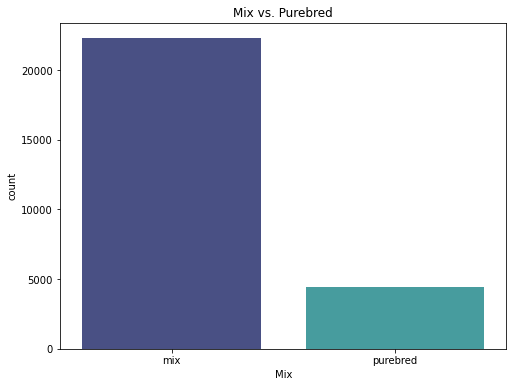

In [203]:
figure = (8, 6)
fig, ax = plt.subplots(figsize = figure)

plt.title('Mix vs. Purebred')

sns.countplot(pets.Mix, palette='mako');

It appears that it is much more common for a mixed-breed dog to show up in this animal shelter than a purebred dog.

Now, instead of trying to dummify the 'Breed' column, I'm going to use this much-easier 'Mix' column. I'd also like to take a look at the distribution of Outcomes here:

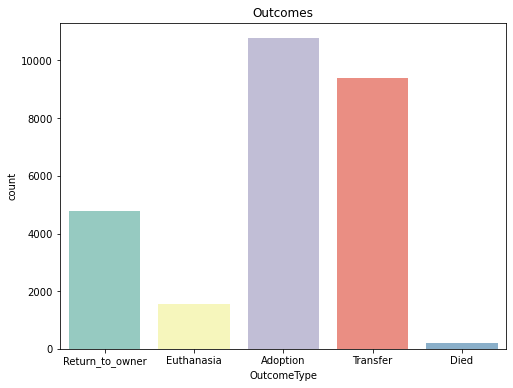

In [201]:
figure = (8, 6)
fig, ax = plt.subplots(figsize = figure)

plt.title('Outcomes')

sns.countplot(pets.OutcomeType, ax = ax, palette='Set3');

So, as we saw with the baseline accuracy above, it's nice to know that most animals are either adopted, transfered to a partner shelter, or returned to their owners.

I'm also going to use their function to whittle down the Age column, which, at the moment, is in years, months, weeks, and even days! Let's make it all in years:

In [109]:
def calc_age_in_years(x):
    x = str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

In [111]:
pets['AgeInYears'] = pets.AgeuponOutcome.apply(calc_age_in_years)

Plotting to see the distribution of adopted animals by their ages:

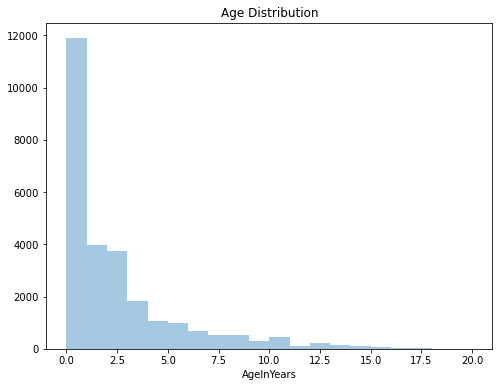

In [202]:
figure = (8, 6)
fig, ax = plt.subplots(figsize = figure)

plt.title('Age Distribution')

sns.distplot(pets.AgeInYears, bins = 20, ax = ax, kde=False);

So, the sad story is, as an animal gets older, it's less likely to be adopted. Fixing the DateTime column:

In [119]:
pets['DateTime'] = pd.to_datetime(pets['DateTime'])

In [120]:
pets['year_month'] = pets['DateTime'].map(lambda x: 100*x.year + x.month)

In [121]:
pets['year'] = pets['DateTime'].map(lambda x: x.year)

In [123]:
pets['Month'] = pets['DateTime'].map(lambda x: x.month)

Now that we've done some feature engineering let's select our X and y variables.

In [124]:
pets.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'Mix', 'AgeInYears', 'year_month', 'year', 'Month'],
      dtype='object')

In [167]:
X = pets.drop(columns = ['AnimalID', 'Name', 'DateTime', 'OutcomeType',
                        'OutcomeSubtype', 'AgeuponOutcome',
                        'Breed', 'Color'])
y = pets.OutcomeType

In [208]:
X['ID'] = X.index + 1

In [211]:
X[0] = X['ID']

In [217]:
X = X[['ID', 'AnimalType', 'SexuponOutcome', 'Mix', 'AgeInYears',
      'year_month', 'year', 'Month']]

In [218]:
X.head()

,ID,AnimalType,SexuponOutcome,Mix,AgeInYears,year_month,year,Month
0,1,Dog,Neutered Male,mix,1.000000,201402,2014,2
1,2,Cat,Spayed Female,mix,1.000000,201310,2013,10
2,3,Dog,Neutered Male,mix,2.000000,201501,2015,1
3,4,Cat,Intact Male,mix,0.057692,201407,2014,7
4,5,Dog,Neutered Male,purebred,2.000000,201311,2013,11


In [138]:
y.shape

(26710,)

In [219]:
y_new = y.map({'Adoption' : 1, 'Transfer' : 2, 'Return_to_owner' : 3,
                'Euthanasia' : 4, 'Died' : 5})

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y_new,
                                                   random_state = 42)

In [221]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [222]:
X_train.shape

(20032, 14)

In [223]:
y_train.shape

(20032,)

In [224]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Since this dataset is so big, I'm going to jump right into Random Forest and not try Logistic Regression, which might bust. Let's see how Random Forest does on THIS version:

In [225]:
rf = RandomForestClassifier(random_state = 42)

rf.fit(X_train_sc, y_train)
cross_val_score(rf, X_train_sc, y_train).mean()

0.5764774475421881

Okay, so that's worse! Let's try a neural net on this puppy (pun intended).

In [226]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [227]:
y_train.shape

(20032, 5)

In [231]:
model_3 = Sequential()

model_3.add(Dense(14,
               activation = 'relu',
                  input_dim = 14))

model_3.add(Dense(8,
               activation = 'relu'))

model_3.add(Dense(8,
               activation = 'relu'))

model_3.add(Dense(5,
               activation = 'softmax'))

In [232]:
model_3.compile(optimizer = 'adam',
             metrics = ['accuracy'],
             loss = 'categorical_crossentropy')

In [233]:
res_3 = model_3.fit(X_train_sc, y_train,
                epochs = 20,
                batch_size = 512,
                validation_data = (X_test_sc, y_test),
                verbose = 1)

Epoch 1/20
40/40 [==============================] - 0s 8ms/step - loss: 1.5451 - accuracy: 0.3545 - val_loss: 1.4582 - val_accuracy: 0.3745
Epoch 2/20
40/40 [==============================] - 0s 3ms/step - loss: 1.4123 - accuracy: 0.3986 - val_loss: 1.3658 - val_accuracy: 0.4576
Epoch 3/20
40/40 [==============================] - 0s 3ms/step - loss: 1.3361 - accuracy: 0.5108 - val_loss: 1.3026 - val_accuracy: 0.5586
Epoch 4/20
40/40 [==============================] - 0s 3ms/step - loss: 1.2713 - accuracy: 0.5821 - val_loss: 1.2386 - val_accuracy: 0.5936
Epoch 5/20
40/40 [==============================] - 0s 3ms/step - loss: 1.2045 - accuracy: 0.5995 - val_loss: 1.1726 - val_accuracy: 0.6065
Epoch 6/20
40/40 [==============================] - 0s 3ms/step - loss: 1.1358 - accuracy: 0.6105 - val_loss: 1.1087 - val_accuracy: 0.6117
Epoch 7/20
40/40 [==============================] - 0s 3ms/step - loss: 1.0748 - accuracy: 0.6167 - val_loss: 1.0572 - val_accuracy: 0.6126
Epoch 8/20
40/40 [==

Okay, still not a great score, but we're going with this one. Let's read in the test data and make predictions.

In [205]:
pets_test = pd.read_csv('./test.csv.gz')

In [207]:
pets_test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [235]:
pets_test.shape

(11456, 8)

In order to run my model on my test data, I have to reshape it so it's the same as my X data.

In [243]:
features = list(X.columns)

In [244]:
pets_test['AgeInYears'] = pets_test.AgeuponOutcome.apply(calc_age_in_years)

In [245]:
pets_test['Mix'] = pets_test.Breed.apply(get_mix)

In [248]:
pets_test['DateTime'] = pd.to_datetime(pets_test['DateTime'])

pets_test['year_month'] = pets_test['DateTime'].map(lambda x: 100*x.year + x.month)

pets_test['year'] = pets_test['DateTime'].map(lambda x: x.year)

pets_test['Month'] = pets_test['DateTime'].map(lambda x: x.month)

In [249]:
pets_test.columns

Index(['ID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome',
       'AgeuponOutcome', 'Breed', 'Color', 'AgeInYears', 'Mix', 'year_month',
       'year', 'Month'],
      dtype='object')

In [250]:
pets_test = pets_test[features]

In [255]:
pets_test = pd.get_dummies(pets_test)

In [256]:
pets_test.shape

(11456, 14)

In [257]:
preds = model_3.predict(pets_test)

In [261]:
preds = pd.DataFrame(preds)

In [263]:
preds['ID'] = pets_test['ID']

In [265]:
preds = preds[['ID', 0, 1, 2, 3, 4]]

In [266]:
preds.head()

,ID,0,1,2,3,4
0,1,1.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0
3,4,1.0,0.0,0.0,0.0,0.0
4,5,1.0,0.0,0.0,0.0,0.0


In [270]:
preds = preds.rename(columns = {0 : 'Adoption', 1 : 'Died', 2 : 'Euthanasia', 
                                3 : 'Return_to_owner', 4 : 'Transfer'})

In [272]:
preds.dtypes

ID                   int64
Adoption           float32
Died               float32
Euthanasia         float32
Return_to_owner    float32
Transfer           float32
dtype: object

In [274]:
preds.to_csv('submission.csv', index = False)